In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from glob import glob
from os import path
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
plt.style.use('notebook')

import mplcursors

import time

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

from mythicwind.csv_io import read_frame, read_frames_parallel
from mythicwind.ellipse import *
from mythicwind.report import *
from mythicwind.gps import *

%matplotlib notebook

def correctHeading(x, headingCorrection):

    """

    corrects a given column of directional data with the given headingCorrection

    """

    if x + headingCorrection > 360:
        return (x + headingCorrection) - 360
    else:
        return x + headingCorrection## transform wind an wave direction into the nacelle CS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def report_timeseries(data, start, end, landing, smoothing_window='10min', resample_period='2s', ylim_deflection=(0, 0.5), savefig_path=None):

    landing_start = landing - pd.to_timedelta(5, unit='m')
    # landing_end = landing + pd.to_timedelta(5, unit='m')
    landing_end = landing + pd.to_timedelta('30s')
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, sharex=True, figsize=(22,11))

    # ax1.plot(data[start:end].max_deflection.rolling(smoothing_window).mean(), color='tab:red')
    ax1.plot(data[start:end].max_deflection, color='tab:red')
    if landing: ax1.axvline(x=landing, color='tab:red')
    ax1.set_ylabel('max. deflection (m)')
    ax1.set_ylim(ylim_deflection)

    # ax2.plot(data[start:end].p2p_angle_signed.rolling(smoothing_window).mean(), color='tab:orange')
    ax2.plot(data[start:end].p2p_azimuth, color='tab:orange')
    if landing: ax2.axvline(x=landing, color='tab:red')
    ax2.set_ylabel('p2p azimuth (deg)')
        
    # ax3.plot(data[start:end].p2p_angle_signed.rolling(smoothing_window).mean().diff()[1:], color='gold')
    ax3.plot(data[start:end].ddt_p2p_azimuth, color='gold')
    if landing: ax3.axvline(x=landing, color='tab:red')
    ax3.set_ylabel('d/dt (p2p azimuth) (deg/s)')
    ax3.set_ylim([-180, 180])

    # ax4.plot(data[start:end].axis_ratio.rolling(smoothing_window).mean(), color='tab:green')
    ax4.plot(data[start:end].axis_ratio, color='tab:green')
    if landing: ax4.axvline(x=landing, color='tab:red')
    ax4.set_ylabel('axis ratio (-)')
    
    ax5.plot(data[start:end].ddt_axis_ratio, color='tab:purple')
    if landing: ax5.axvline(x=landing, color='tab:red')
    ax5.set_ylabel('d/dt (axis ratio) (1/s)')
    ax5.set_ylim([-1, 1])
    fig.tight_layout()
    
    if savefig_path: fig.savefig(savefig_path, dpi=300)

def report_scatter(data, start, end, landing, delta_t_landing='5min', smoothing_window='10min', resample_period='2s', ylim_deflection=(0, 0.5), savefig_path=None):
    
    landing_start = landing - pd.to_timedelta(delta_t_landing)
    landing_end = landing + pd.to_timedelta('30s')
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(22,22))
    
    ax1.scatter(data[start:end].p2p_azimuth, data[start:end].max_deflection, facecolor='tab:red', edgecolor='none', alpha=0.2, s=10)
    ax1.scatter(data[landing_start:landing_end].p2p_azimuth, data[landing_start:landing_end].max_deflection, facecolor='tab:red', edgecolor='white')
    ax1.set_xlabel('p2p azimuth (deg)')
    ax1.set_ylabel('max. deflection (m)')
    ax1.set_ylim(ylim_deflection)
    ax1.grid()
    
    ax2.scatter(data[start:end].axis_ratio, data[start:end].max_deflection, facecolor='tab:red', edgecolor='none', alpha=0.2, s=10)
    ax2.scatter(data[landing_start:landing_end].axis_ratio, data[landing_start:landing_end].max_deflection, facecolor='tab:red', edgecolor='white')
    ax2.set_xlabel('axis ratio (-)')
    ax2.set_ylabel('max. deflection (m)')
    ax2.set_ylim(ylim_deflection)
    ax2.grid()
    
    ax3.scatter(data[start:end].ddt_p2p_azimuth, data[start:end].max_deflection, facecolor='tab:red', edgecolor='none', alpha=0.2, s=10)
    ax3.scatter(data[landing_start:landing_end].ddt_p2p_azimuth, data[landing_start:landing_end].max_deflection, facecolor='tab:red', edgecolor='white')
    ax3.set_xlabel('d/dt (p2p azimuth) (deg/s)')
    ax3.set_ylabel('max. deflection (m)')
    ax3.set_ylim(ylim_deflection)
    ax3.set_xlim([-180, 180])
    ax3.grid()
    
    ax4.scatter(data[start:end].eccentricity, data[start:end].ddt_p2p_angle_signed, facecolor='tab:red', edgecolor='none', alpha=0.2, s=10)
    ax4.scatter(data[landing_start:landing_end].eccentricity, data[landing_start:landing_end].ddt_p2p_angle_signed, facecolor='tab:red', edgecolor='white')
    ax4.set_xlim([1, 0])
    ax4.set_xlabel('eccentricity')
    ax4.set_ylabel('d/dt (p2p azimuth) (deg/s)')
    ax4.set_ylim([-180, 180])
    ax4.grid()
    
    ax5.scatter(data[start:end].axis_ratio, data[start:end].ddt_p2p_azimuth, facecolor='tab:red', edgecolor='none', alpha=0.2, s=10)
    ax5.scatter(data[landing_start:landing_end].axis_ratio, data[landing_start:landing_end].ddt_p2p_azimuth, facecolor='tab:red', edgecolor='white')
    ax5.set_xlabel('axis ratio (-)')
    ax5.set_ylabel('d/dt (p2p azimuth) (deg/s)')
    ax5.set_ylim([-180, 180])
    ax5.grid()
    
    ax6.scatter(data[start:end].ddt_axis_ratio, data[start:end].max_deflection, facecolor='tab:red', edgecolor='none', alpha=0.2, s=10)
    ax6.scatter(data[landing_start:landing_end].ddt_axis_ratio, data[landing_start:landing_end].max_deflection, facecolor='tab:red', edgecolor='white')
    ax6.set_xlabel('d/dt (axis ratio) (1/s)')
    ax6.set_ylabel('max. deflection (m)')
    ax6.set_ylim(ylim_deflection)
    ax6.set_xlim([-1, 1])
    ax6.grid()
    
    ax7.scatter(data[start:end].p2p_azimuth, data[start:end].ddt_p2p_azimuth, facecolor='tab:red', edgecolor='none', alpha=0.2, s=10)
    ax7.scatter(data[landing_start:landing_end].p2p_azimuth, data[landing_start:landing_end].ddt_p2p_azimuth, facecolor='tab:red', edgecolor='white', alpha=0.2, s=10)
    ax7.set_xlabel('p2p azimuth (deg)')
    ax7.set_ylabel('d/dt (p2p azimuth) (deg/s)')
    ax7.set_ylim([-180, 180])
    #ax7.set_xlim([-1, 1])
    ax7.grid()
    
    fig.tight_layout()
    
    # fig.canvas.mpl_connect('pick_event', onpick)
    
    if savefig_path: fig.savefig(savefig_path, dpi=300)
    
def report_distributions(data, start, end, landing, smoothing_window='10min', resample_period='2s', savefig_path=None):
    
    # deflection_p2pRatio = data[start:end].max_deflection.rolling(smoothing_window).mean()/data[start:end].axis_ratio.rolling(smoothing_window).mean()
    # grad_p2p = data[start:end].p2p_angle_signed.resample(resample_period).mean().diff()[1:].fillna(method='ffill')
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(22,11))
    
    ax1.hist(data[start:end].max_deflection, bins=50,)
    ax1.set_xlabel('max. deflection (m)')
    
    ax2.hist(data[start:end].p2p_angle_signed, bins=50,)
    ax2.set_xlabel('p2p azimuth (deg)')
    
    ax3.hist(data[start:end].axis_ratio, bins=50,)
    ax3.set_xlabel('axis ratio (-)')
    
    ax4.hist(data[start:end].ddt_p2p_angle_signed, bins=50,)
    ax4.set_xlabel('d/dt(p2p azimuth) (deg/sec)')
    fig.tight_layout()
    
    if savefig_path: fig.savefig(savefig_path, dpi=300)
   
    #ax1.hist(data[start:end].max_deflection, bins='fd',)

In [4]:
"""
turbine-08,2019-10-15 09:05,2019-10-15 10:05,00:59:55,1571123113,1571126708
turbine-08,2019-10-15 16:28,2019-10-15 17:47,01:18:50,1571149693,1571154423
turbine-08,2019-10-16 03:07,2019-10-16 04:35,01:28:24,1571188044,1571193348
"""

data_dir = '../data/turbines/turbine-08/'

sbi_delta_t = pd.to_timedelta(1, unit='h')

nacelle_installation_end = pd.to_datetime('1571050800', unit='s', utc=True)

blade1_landing = pd.to_datetime('1571123113', unit='s', utc=True)
blade2_landing = pd.to_datetime('1571149693', unit='s', utc=True)
blade3_landing = pd.to_datetime('1571188044', unit='s', utc=True)

blade_landings = (blade1_landing, blade2_landing, blade3_landing)

blade1_start = blade1_landing - sbi_delta_t
blade1_end = blade1_landing + sbi_delta_t

blade2_start = blade2_landing - sbi_delta_t
blade2_end = blade2_landing + sbi_delta_t

blade3_start = blade3_landing - sbi_delta_t
blade3_end = blade3_landing + sbi_delta_t

In [ ]:
data = dict()
data_raw = dict()
gnss_data = dict()
lidar = list()
waves = list()

for pos in ('helihoist-1', 'sbitroot', 'sbittip'):
    pos_dir = path.join(data_dir, pos)
    if path.isdir(pos_dir):
        print(f'processing {pos_dir}')
        
#        raw_data = path.join(pos_dir, 'tom/clean')
#        if path.isdir(raw_data):
#            data_raw[pos] = pd.concat(read_frames_parallel(raw_data))
        
        pos_data = path.join(pos_dir, 'tom/acc-vel-pos')
        if path.isdir(pos_data):
            data[pos] = pd.concat(read_frames_parallel(pos_data))
            data[pos] = data[pos].resample('33ms').mean().fillna('')

        gnss_file = path.join(pos_dir, f'tom/gps/turbine-08_{pos}_tom_gps.csv')
        if path.isfile(gnss_file):
            # print(f'found gnss file: {gnss_file}')
            gnss_data[pos] = read_frame(gnss_file)

for i in (13, 14, 15, 16):
    lidar.append(read_frame(glob(f'../data/environment/wind/lidar/lidar_2019-10-{i}.csv')[0]))
    waves.append(read_frame(glob(f'../data/environment/waves/wmb-sued/wmb-sued_2019-10-{i}.csv')[0]))

lidar = pd.concat(lidar)
waves = pd.concat(waves)

lidar.insert(loc = len(lidar.columns), column = 'tu_3', value = lidar.wind_speed_3.rolling('10min').apply(lambda x : np.std(x) / np.mean(x)))

processing ../data/turbines/turbine-08/helihoist-1
processing ../data/turbines/turbine-08/sbitroot


In [6]:
#Dataset_raw = namedtuple('Dataset_raw', ['helihoist', 'sbitroot', 'sbittip'])
Dataset = namedtuple('Dataset', ['helihoist', 'lidar', 'waves'])
GeometryDataset = namedtuple('GeomtryDataset', ['helihoist', 'lidar', 'waves'])
GNSS = namedtuple('GNSS', ['helihoist', 'sbitroot', 'sbittip'])

#turbine_8_raw = Dataset_raw(data_raw['helihoist-1'], data_raw['sbitroot'], data_raw['sbittip'])
turbine_8 = Dataset(data['helihoist-1'], lidar, waves)
turbine_8_gnss = GNSS(gnss_data['helihoist-1'], gnss_data['sbitroot'], gnss_data['sbittip'])

del(data)

## Detect installation stages with gnss

<IPython.core.display.Javascript object>


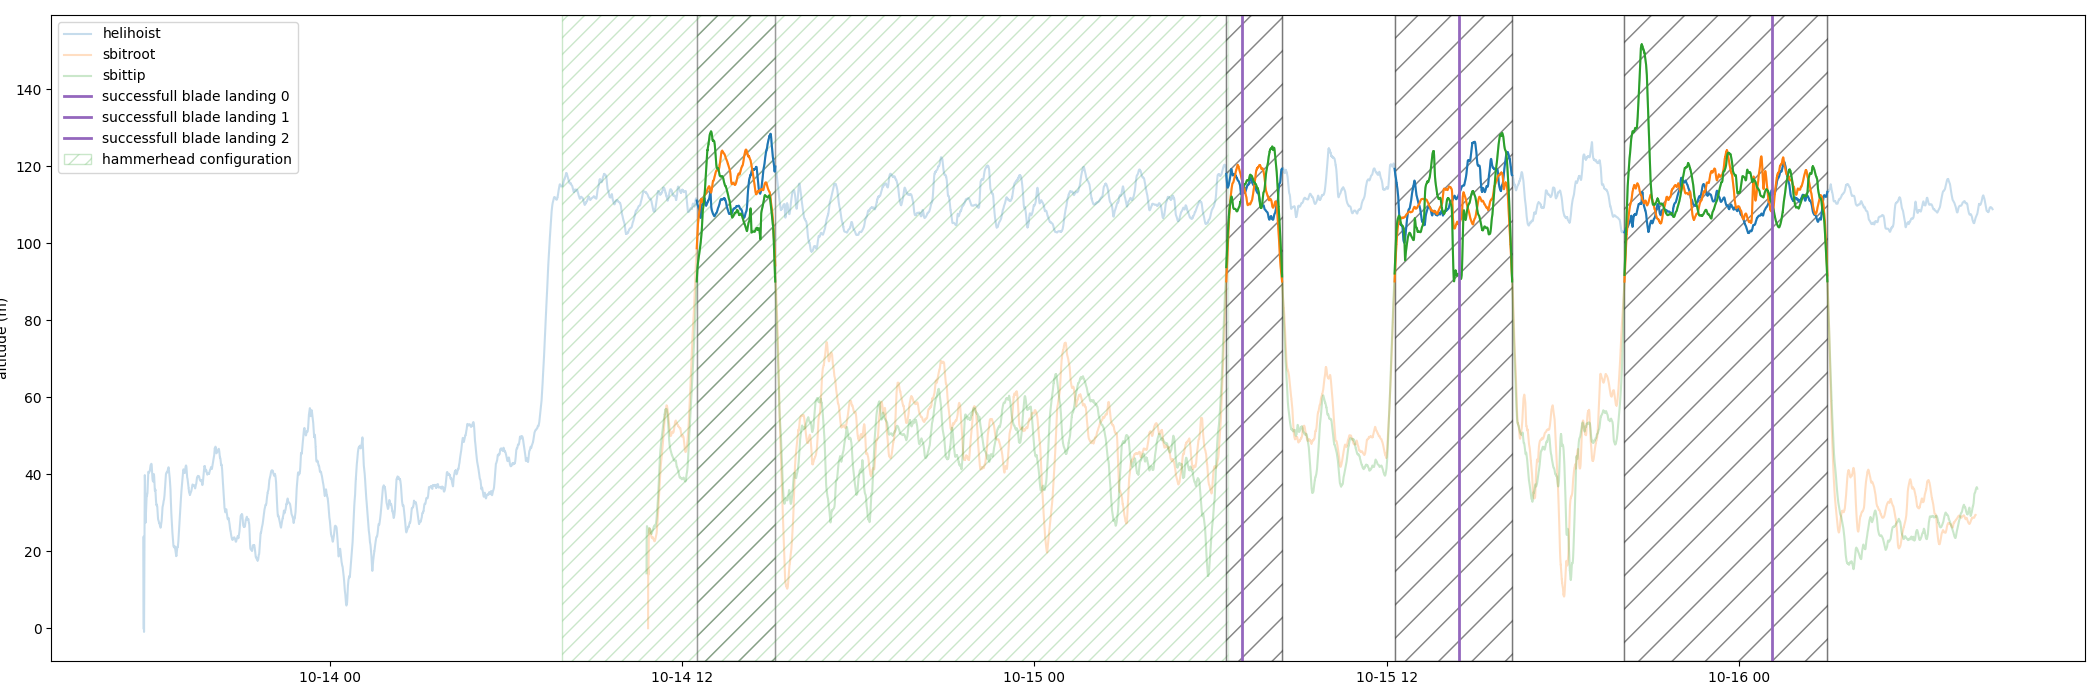

0
1
2
0
first successful blade landing
1
2
0
1
2
0
1
2


In [7]:
sbi_limit = 90

hh, sr, st = (turbine_8_gnss.helihoist.altitude.resample('1s').mean().rolling('20min').mean(), turbine_8_gnss.sbitroot.altitude.resample('1s').mean().rolling('20min').mean(), turbine_8_gnss.sbittip.altitude.resample('1s').mean().rolling('20min').mean())

hammerhead_start = hh[hh > sbi_limit].index[0] + pd.to_timedelta('30min')

hh_sbi = hh[(hh > sbi_limit) & (sr > sbi_limit) & (st > sbi_limit)]
sr_sbi = sr[(hh > sbi_limit) & (sr > sbi_limit) & (st > sbi_limit)]
st_sbi = st[(hh > sbi_limit) & (sr > sbi_limit) & (st > sbi_limit)]


ii = hh_sbi[hh_sbi.index.to_series().diff() > pd.to_timedelta(60, unit='s')].index.to_list()
ii.insert(0, hh_sbi.index[0])
ii.insert(len(ii), hh_sbi.index[-1])

sbi_indices = list()

for i in range(len(ii) - 1):
    sbi_indices.append((ii[i], hh_sbi[ii[i]:ii[i+1]].index[-2]))

plt.figure()    

plt.plot(hh, alpha=0.25, label='helihoist')
plt.plot(sr, alpha=0.25, label='sbitroot')
plt.plot(st, alpha=0.25, label='sbittip')

for (start, end) in sbi_indices:
    plt.plot(hh[start:end], color='tab:blue')
    plt.plot(sr[start:end], color='tab:orange')
    plt.plot(st[start:end], color='tab:green')
    
    for blade_landing_i, blade_landing in enumerate(blade_landings):
        print(blade_landing_i)
        plt.axvspan(xmin=start, xmax=end, hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
        if blade_landing > start and blade_landing < end:
            plt.axvline(x=blade_landing, color='tab:purple', linewidth=2, label=f'successfull blade landing {blade_landing_i}')
            if blade_landing_i == 0:
                print(f'first successful blade landing')
                hammerhead_end = blade_landing - pd.to_timedelta('30min')
                plt.axvspan(xmin=hammerhead_start, xmax=hammerhead_end, label='hammerhead configuration', facecolor='white', alpha=0.25, edgecolor='tab:green', hatch='//')
plt.tight_layout()
plt.ylabel('altitude (m)')
plt.legend(loc='upper left')
# mplcursors.cursor(hover=True)

plt.savefig('../results/turbine-08/GNSS.png', dpi=300)

## Spectogram of the TNH during installation

<IPython.core.display.Javascript object>


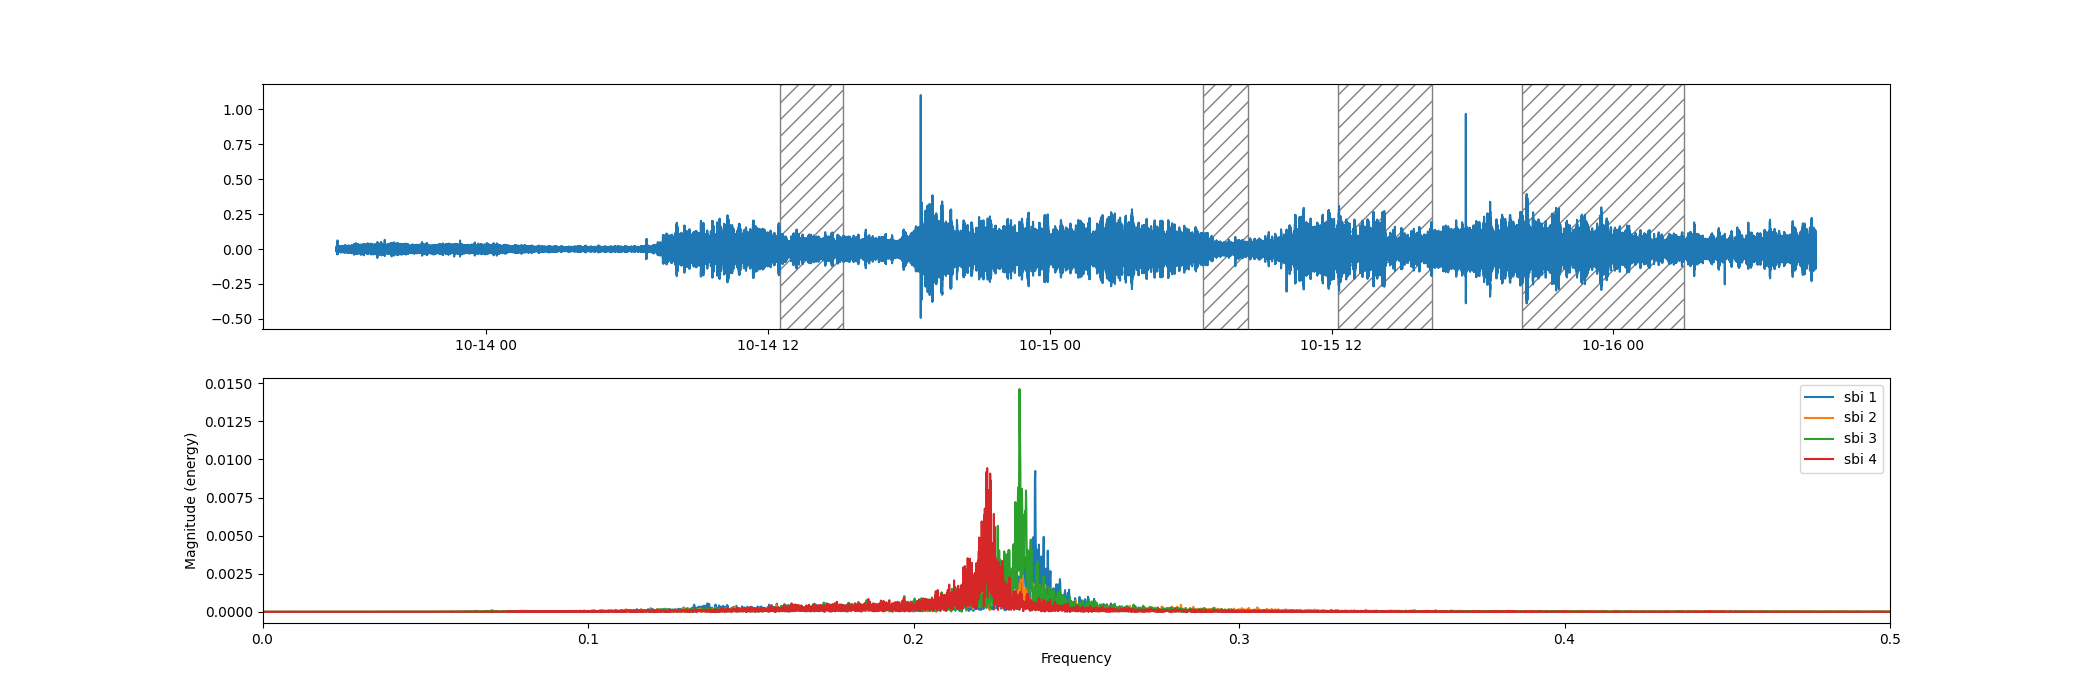

In [83]:
NFFT = 4096  # the length of the windowing segments
Fs = int(1.0 / 0.1)  # the sampling frequency

fig, (ax1, ax2) = plt.subplots(nrows=2)

ax1.plot(turbine_8.helihoist.pos_x)

# Pxx, freqs, bins, im = ax2.specgram(turbine_8.helihoist.pos_x, NFFT=NFFT, Fs=Fs, noverlap=200)

for i, (start, end) in enumerate(sbi_indices):
    ax1.axvspan(xmin=start, xmax=end, facecolor='none', edgecolor='grey', hatch='//')
    ax2.magnitude_spectrum(turbine_8.helihoist[start:end].pos_x.resample('100ms').mean().fillna(method='ffill'), Fs=Fs, label=f'sbi {i+1}')

#ax2.magnitude_spectrum(turbine_8.helihoist[hammerhead_start:hammerhead_end].pos_x.resample('100ms').mean().fillna(method='ffill'), Fs=Fs, color='grey', label='hammerhead')
ax2.set_xlim((0, 0.5))
ax2.legend()

## Estimate nacelle orientation during installation

single blade installation start 2019-10-14 12:50:00+00:00 to 2019-10-16 02:40:00+00:00
sbit vector: (0.00034023640217004623, -0.0002229097710061967)
nacelle orientation due north: 33


<IPython.core.display.Javascript object>


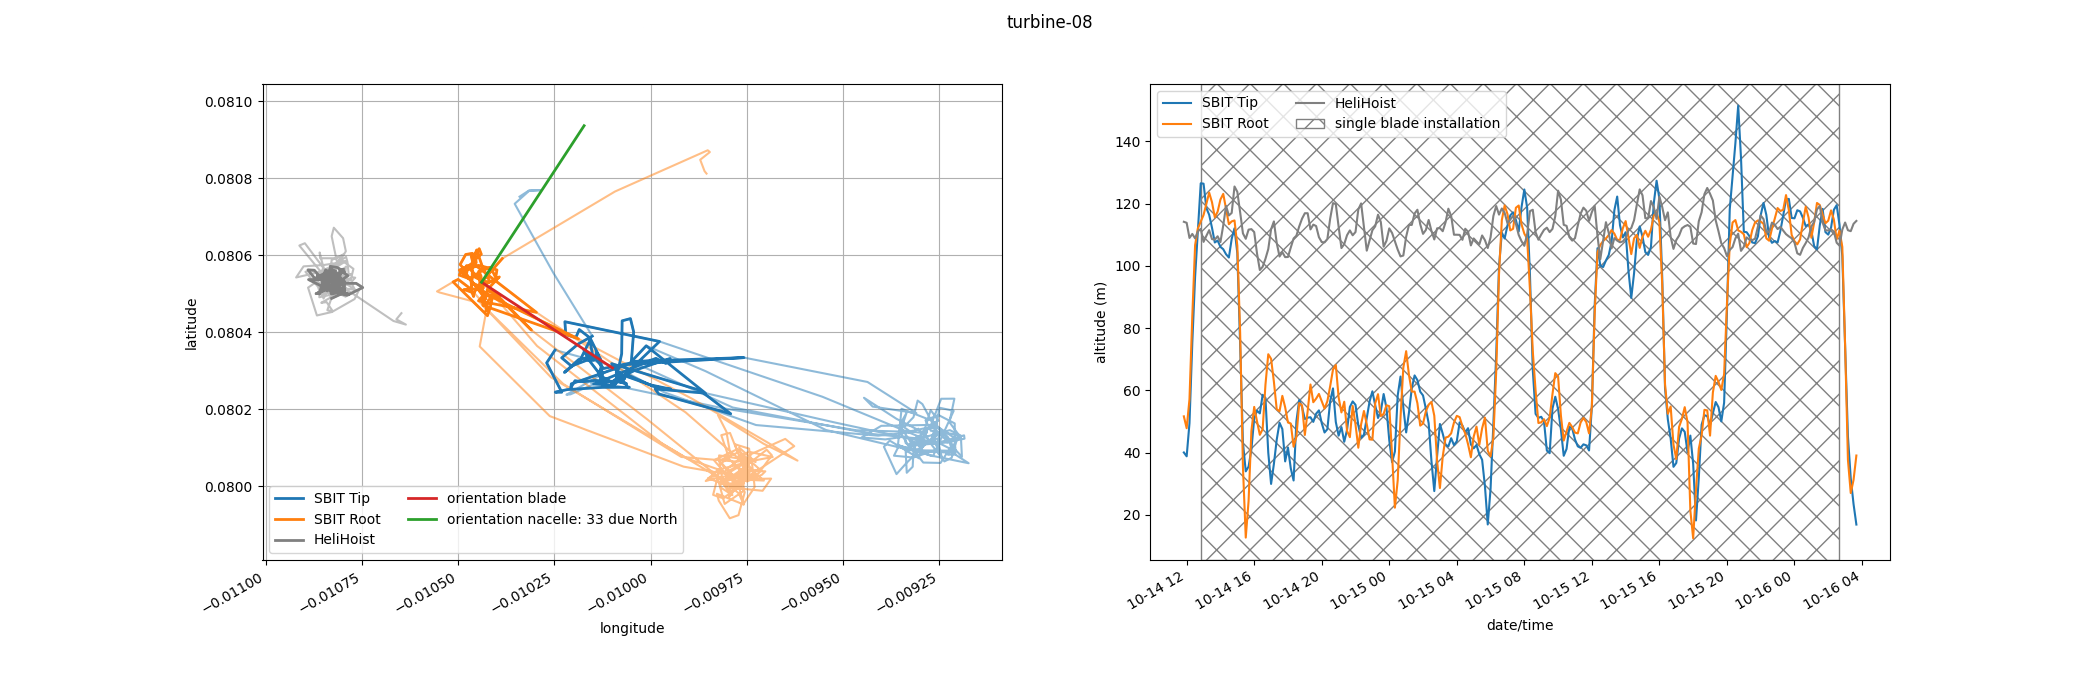

In [9]:
hh, sr, st, ii = estimate_sbi(helihoist=turbine_8_gnss.helihoist,
                              sbitroot=turbine_8_gnss.sbitroot,
                              sbittip=turbine_8_gnss.sbittip,
                             )
if not len(ii) > 0:
    print(f'failed to identify installation times for {name}... skipping')

sbi_start = ii[0]
sbi_stop = ii[-1]
print(f'single blade installation start {sbi_start} to {sbi_stop}')

sbitroot_v, sbit_v, nacelle_v, nacelle_angle = estimate_nacelle_orientation(sbitroot_gps=sr,
                                                                            sbittip_gps=st,
                                                                            sbi_time_index=ii,
                                                                           )

plot_sbi(sbitroot_gps=sr,
         sbittip_gps=st,
         helihoist_gps=hh,
         sbitroot_v=sbitroot_v,
         sbit_v=sbit_v,
         nacelle_v=nacelle_v,
         sbi_time_indices=ii,
         turbine_name='turbine-08',
         output_dir='../results/turbine-08/',
         nacelle_angle=nacelle_angle,
        )

In [33]:
t8g = geometry_analysis(t8)

In [24]:
min_df, max_df = find_minmax_deflection(t8)
ratio_df = calc_axis_ratio(min_df.min_deflection, max_df.max_deflection)
p2p_angles_df = calc_p2p_angles(t8.pos_z, t8.pos_x, max_df)
axis_angles_df = calc_max_deflection_angles(t8.pos_z, t8.pos_x, max_df)

In [28]:
# merge DataFrame and return
geometry_df = pd.merge(max_df, ratio_df,
                       left_index=True, right_index=True)
geometry_df = pd.merge(geometry_df, axis_angles_df,
                       left_index=True, right_index=True)
geometry_df = pd.merge(geometry_df, p2p_angles_df,
                       left_index=True, right_index=True)

In [29]:
geometry_df

,max_deflection,max_deflection_i,ddt_max_deflection,axis_ratio,eccentricity,ddt_axis_ratio,ddt_eccentricity,axis_angle_signed,axis_angle_unsigned,axis_azimuth,ddt_axis_angle_signed,ddt_axis_angle_unsigned,p2p_angle_unsigned,p2p_angle_signed,p2p_azimuth,p2p_azimuth_unwrapped,ddt_p2p_azimuth_unwrapped,ddt_p2p_azimuth,ddt_p2p_angle_unsigned,ddt_p2p_angle_signed
epoch,,,,,,,,,,,,,,,,,,,,
2019-10-14 07:55:29.457000017+00:00,0.050802,44,0.000610,0.382938,0.923774,-0.160052,0.036949,-157.415705,157.415705,202.584295,7.750926,-7.750926,147.569520,-147.569520,212.430480,212.430480,8.206186,8.206186,-8.206186,8.206186
2019-10-14 07:55:33.648000002+00:00,0.058705,171,0.002178,0.191312,0.981529,0.048308,-0.008178,-124.931572,124.931572,235.068428,3.772086,-3.772086,124.944582,-124.944582,235.055418,235.055418,1.232493,1.232493,-1.232493,1.232493
2019-10-14 07:55:38.003999949+00:00,0.053532,303,-0.003843,0.068557,0.997647,0.013016,-0.003357,-126.514553,126.514553,233.485447,2.600420,-2.600420,124.717705,-124.717705,235.282295,235.282295,2.999747,2.999747,-2.999747,2.999747
2019-10-14 07:55:42.062999964+00:00,0.047908,426,0.002634,0.359481,0.933153,-0.023444,0.006311,-104.749528,104.749528,255.250472,2.485272,-2.485272,99.255334,-99.255334,260.744666,260.744666,3.191767,3.191767,-3.191767,3.191767
2019-10-14 07:55:46.154999971+00:00,0.061100,550,0.003463,0.206645,0.978416,0.022894,-0.006213,-106.447752,106.447752,253.552248,-0.855811,0.855811,110.871312,-110.871312,249.128688,249.128688,-2.992059,-2.992059,2.992059,-2.992059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15 06:34:48.026999950+00:00,0.062985,2469118,-0.005386,0.275399,0.961330,0.045460,-0.011836,174.345346,174.345346,174.345346,-38.818265,0.639046,177.751781,177.751781,177.751781,6657.751781,2.313133,2.313133,0.873355,-80.952884
2019-10-15 06:34:52.448999882+00:00,0.057272,2469252,-0.003328,0.357959,0.933737,0.026688,-0.011831,-175.136164,175.136164,184.863836,-38.960976,0.591590,176.650226,-176.650226,183.349774,6663.349774,-0.497541,-0.497541,0.497541,-0.497541
2019-10-15 06:34:56.640000105+00:00,0.030764,2469379,-0.003439,0.544760,0.838592,0.021700,-0.012670,-179.254998,179.254998,180.745002,2.704257,-2.704257,172.138291,-172.138291,187.861709,6667.861709,4.824187,4.824187,-4.824187,4.824187


<IPython.core.display.Javascript object>


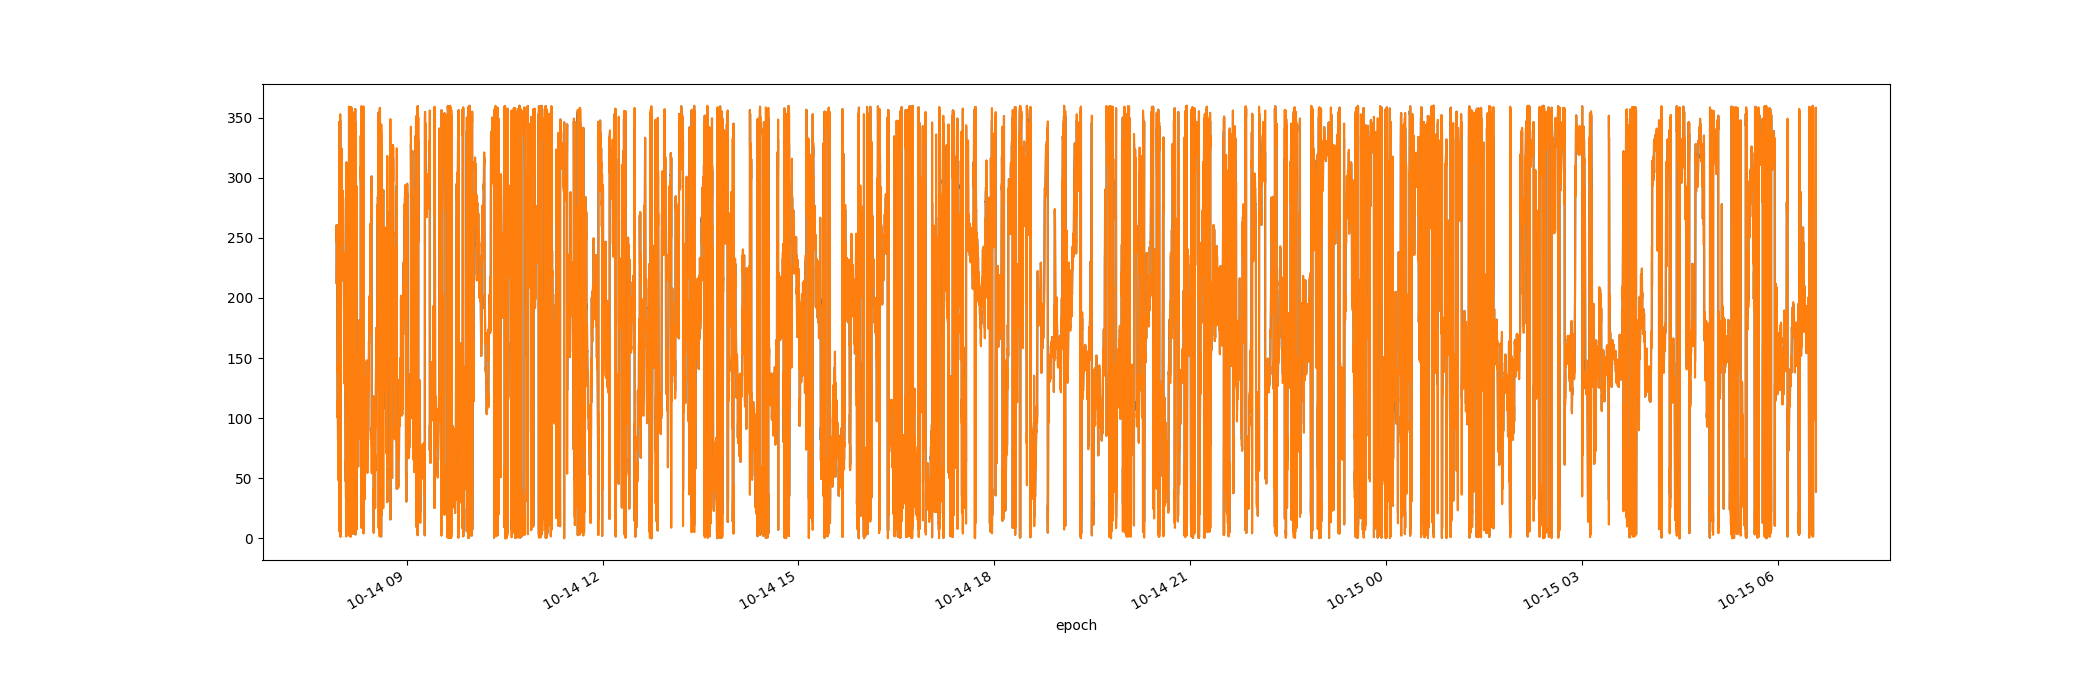

In [49]:
plt.figure()
geometry_df.p2p_azimuth.plot()
p2p_angles_df.p2p_azimuth.plot()